## PCA and K-means clustering with Spark and MLlib

In this notebook, we will take the Iris dataset from Sklearn, and import it into a pyspark Dataframe. From there, we will perform Principal Component Analysis to reduce it to 3 dimensions, and then perform K-means clustering using the build in MLlib PCA.

In [1]:
# Use snippet when installing from pip in jupyter
# import sys
# !{sys.executable} -m pip install --upgrade matplotlib

# Retrieves Iris dataset from sklearn, saves as csv to use in Pyspark
def get_dataset():
    from sklearn.datasets import load_iris
    import numpy as np

    data = load_iris()
    x = data.data
    y = data.target.reshape((150, 1))

    # join iris data with labels
    dataset = np.concatenate((x, y), axis=1)

    np.savetxt('iris_dataset.csv', dataset, delimiter=',')

In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

# Create sparkcontext. Represents connection to Spark cluster
sc = SparkContext(appName='PCAIris')
# Create SqlContext for native reading of csv files
sqlContext = SQLContext(sc)

In [3]:
from pyspark.sql.types import IntegerType
import numpy as np

# Iris dataset- 3 different types of irises’ (Setosa, Versicolour, and Virginica)
# 4 features: Sepal Length, Sepal Width, Petal Length and Petal Width.
iris_path = 'iris_dataset.csv'
columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']

# read in csv data
df = sqlContext.read.csv(iris_path, header=False, inferSchema=True)
# rename columns for readability
df = df.toDF(*columns)

# cast label column to integer and increment by 1 to match predictions returned by k-means
df = df.withColumn('label', df['label'].cast(IntegerType()))
labels = np.asarray([label[0] for label in df.select('label').collect()]).reshape(150,1)

In [4]:
df.show(10)

+------------+-----------+------------+-----------+-----+
|sepal_length|sepal_width|petal_length|petal_width|label|
+------------+-----------+------------+-----------+-----+
|         5.1|        3.5|         1.4|        0.2|    0|
|         4.9|        3.0|         1.4|        0.2|    0|
|         4.7|        3.2|         1.3|        0.2|    0|
|         4.6|        3.1|         1.5|        0.2|    0|
|         5.0|        3.6|         1.4|        0.2|    0|
|         5.4|        3.9|         1.7|        0.4|    0|
|         4.6|        3.4|         1.4|        0.3|    0|
|         5.0|        3.4|         1.5|        0.2|    0|
|         4.4|        2.9|         1.4|        0.2|    0|
|         4.9|        3.1|         1.5|        0.1|    0|
+------------+-----------+------------+-----------+-----+
only showing top 10 rows



In [5]:
### used guide from https://towardsdatascience.com/a-brief-introduction-to-pyspark-ff4284701873

# MLlib imports
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

# Create a vector representation of features for PCA
assembler = VectorAssembler(inputCols=columns[0:4],outputCol='grouped_features')
df = assembler.transform(df)

# Scale features to be between 0 and 1
scaler = MinMaxScaler(inputCol="grouped_features", outputCol="scaled_features")
scalerModel = scaler.fit(df)

# rescale each feature to range [min, max].
df = scalerModel.transform(df)

# show first 10 rows of Dataframe
df.show(10)

+------------+-----------+------------+-----------+-----+-----------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|label| grouped_features|     scaled_features|
+------------+-----------+------------+-----------+-----+-----------------+--------------------+
|         5.1|        3.5|         1.4|        0.2|    0|[5.1,3.5,1.4,0.2]|[0.22222222222222...|
|         4.9|        3.0|         1.4|        0.2|    0|[4.9,3.0,1.4,0.2]|[0.16666666666666...|
|         4.7|        3.2|         1.3|        0.2|    0|[4.7,3.2,1.3,0.2]|[0.11111111111111...|
|         4.6|        3.1|         1.5|        0.2|    0|[4.6,3.1,1.5,0.2]|[0.08333333333333...|
|         5.0|        3.6|         1.4|        0.2|    0|[5.0,3.6,1.4,0.2]|[0.19444444444444...|
|         5.4|        3.9|         1.7|        0.4|    0|[5.4,3.9,1.7,0.4]|[0.30555555555555...|
|         4.6|        3.4|         1.4|        0.3|    0|[4.6,3.4,1.4,0.3]|[0.08333333333333...|
|         5.0|        3.4|    

In [6]:
from pyspark.ml.feature import PCA

# Reduce dimensionality to 3 dimensions
pca = PCA(k=3, inputCol='scaled_features', outputCol='pca_features')
model = pca.fit(df)

df = model.transform(df)

# create training dataframe with just 'features' column, as kmeans expects
#train_df = df.select('pca_features').toDF('features')
train_df = df.withColumnRenamed('pca_features', 'features')

In [8]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Define a K-means clustering model with 3 clusters, fit to training data
kmeans = KMeans().setK(3)
model = kmeans.fit(train_df) 

# Train model with scaled PCA features
predictions = model.transform(train_df)

# Evaluate clustering by computing Silhouette score. Score is between -1 and 1, higher is better.
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
    
cluster_centers = [center for center in model.clusterCenters()]

Silhouette with squared euclidean distance = 0.6717338007829551


In [9]:
import numpy as np

cluster_centers = np.asarray(cluster_centers)

# Wrangle Spark dataframe to a more plottable format
features = train_df.select('features').collect()
data = [[features[i][0][j] for j in range(0,3)] for i in range(0, len(features))]
data = np.asarray(data)

# join data with labels for plotting
data = np.concatenate((data, labels), axis=1)

# seperate data by classes
class_0, class_1, class_2 = data[data[:, 3] == 0., :], data[data[:, 3] == 1., :], data[data[:, 3] == 2., :]

# class 0 of iris
x0 = class_0[:,0]
y0 = class_0[:,1]
z0 = class_0[:,2]

# class 1 of iris
x1 = class_1[:,0]
y1 = class_1[:,1]
z1 = class_1[:,2]

# class 2 of iris
x2 = class_2[:,0]
y2 = class_2[:,1]
z2 = class_2[:,2]

# cluster centers
x_c1, x_c2, x_c3 = cluster_centers[0][0], cluster_centers[1][0], cluster_centers[2][0]
y_c1, y_c2, y_c3 = cluster_centers[0][1], cluster_centers[1][1], cluster_centers[2][1]
z_c1, z_c2, z_c3 = cluster_centers[0][2], cluster_centers[1][2], cluster_centers[2][2]

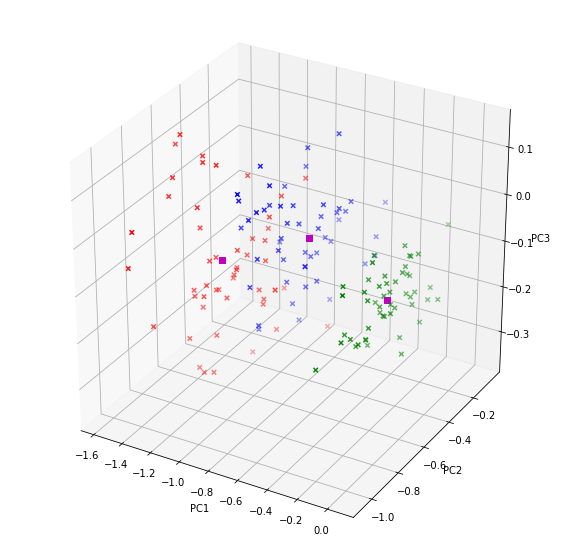

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# class 0 has red points, class 1 green points and class 2 blue points
ax.scatter(x0, y0, z0, color='g', marker="x")
ax.scatter(x1, y1, z1, color='b', marker="x")
ax.scatter(x2, y2, z2, color='r', marker="x")

# plot cluster centers
ax.scatter(x_c1,y_c1,z_c1, marker="s", s=40, color='m')
ax.scatter(x_c2,y_c2,z_c2, marker="s", s=40, color='m')
ax.scatter(x_c3,y_c3,z_c3, marker="s", s=40, color='m')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# plot cluster centroids along with training data
plt.show()

## How did K-means perform
Lets see how well the clustering algorithm was able to differentiate between the 3 classes. In this instance, we know which examples are from which species so we can evaluate the performance of k-means, but if the data were unstructured and unlabelled, we would not be able to do this. First we need to find a mapping of cluster labels to actual labels, since they are unlikely to be the same integer. 

In [31]:
# group together examples that were predicted to be in the came cluster
cluster_0, cluster_1, cluster_2 = predictions.filter('prediction == 0'), predictions.filter('prediction == 1'), predictions.filter('prediction == 2')

def get_label(df):
    # simple function to get most likely label of cluster
    most_likely_label = 0
    count = 0
    for label in range(0,3):
        c = df.filter(f'label == {label}').count()
        if c > count:
            most_likely_label = label
            count = c
    return most_likely_label

cluster_0_label, cluster_1_label, cluster_2_label = get_label(cluster_0), get_label(cluster_1), get_label(cluster_2)

So now we know the mapping of cluster classes to actual class, we can calculate the accuracy of the model.

In [38]:
cluster_0_correct = cluster_0.filter(f'label={cluster_0_label}').count()
cluster_1_correct = cluster_1.filter(f'label={cluster_1_label}').count()
cluster_2_correct = cluster_2.filter(f'label={cluster_2_label}').count()

accuracy = (cluster_0_correct + cluster_1_correct + cluster_2_correct) / predictions.count() * 100

print(f'Total accuracy: {accuracy} \n')

cluster_accuracies = [cluster_0_correct/cluster_0.count(), 
                      cluster_1_correct/cluster_1.count(), 
                      cluster_2_correct/cluster_2.count()]

cluster_labels = [cluster_0_label, cluster_1_label, cluster_2_label]

for i in range(0,3):
    print(f'Cluster {i} (label {cluster_labels[i]}) accuracy: {cluster_accuracies[i]}')


Total accuracy: 88.0 

Cluster 0 (label 2) accuracy: 0.8076923076923077
Cluster 1 (label 0) accuracy: 1.0
Cluster 2 (label 1) accuracy: 0.8333333333333334


 This turns out to be **88%**, which is an acceptable first try. Further analysis shows that the loss in accuracy comes from misclassifications between cluster 0 and cluster 2. Lets look further into this by using a Parallel Coordinates plot, which allows us to visualise high dimensional data such as the Iris data.

In [35]:
import plotly.express as px

fig = px.parallel_coordinates(df.toPandas(), color="label", labels={"species_id": "Species",
                "sepal_width": "Sepal Width", "sepal_length": "Sepal Length",
                "petal_width": "Petal Width", "petal_length": "Petal Length", },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=1)
fig.show()

From the Parallel Coordinates plot, we can see that the class with label 0 has lower values for petal length and petal width, as well has the highest values for sepal width. This resulted in a more successful cluster being learned by the algorithm, and we can see this from the 100% accuracy of the cluster which represented label 0.